# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from xbbg import blp

# Functions

In [2]:


def BloombergRequest(Ticker, Start, End):
    print("Requesting BBG for:",Ticker)
    Pointer = blp.bdh(tickers= [Ticker], start_date = Start , end_date = End)

    Pointer.index = Pointer.index.strftime("%Y%m%d").astype(int)
    Pointer.columns = [Ticker.replace("/", "_")]
    return Pointer

def GetData(Ticker, Start = "20190101", End = pd.Timestamp.today().strftime("%Y%m%d")):
    if Ticker.replace("/", "_") + ".csv" in os.listdir(r"\\10.155.31.149\멀티에셋\Kelian\DATA\MARKET"):   # Folder Location
        #print("Got From DataBase")
        Pointer = pd.read_csv(r"\\10.155.31.149\멀티에셋\Kelian\DATA\MARKET\\" + Ticker.replace("/", "_") + ".csv", index_col=0)
        if Start < str(Pointer.index.min()):
            print("Min")
            Point = BloombergRequest(Ticker, Start, str(Pointer.index.min()))
            Pointer = pd.concat((Pointer, Point), axis = 0)
        if End > str(Pointer.index.max()):
            print("Max")
            Point = BloombergRequest(Ticker, str(Pointer.index.max()), End)
            Pointer = pd.concat((Pointer, Point), axis = 0)
        Pointer = Pointer.loc[~Pointer.index.duplicated(keep='first')].sort_index(ascending=True)
        Pointer.to_csv(r"\\10.155.31.149\멀티에셋\Kelian\DATA\MARKET\\" + Ticker.replace("/", "_") + ".csv", index=True)
    else:
        print("Not in folder")
        Pointer = BloombergRequest(Ticker, Start, End)
        Pointer = Pointer.loc[~Pointer.index.duplicated(keep='first')].sort_index(ascending=True)
        Pointer.to_csv(r"\\10.155.31.149\멀티에셋\Kelian\DATA\MARKET\\" + Ticker.replace("/", "_") + ".csv", index=True)
    
    Pointer = Pointer[Pointer.index >= int(Start)]
    Pointer = Pointer[Pointer.index <= int(End)]
    return Pointer

def AggregateData(Ticker, Start = "20190101", End = pd.Timestamp.today().strftime("%Y%m%d")):
    if isinstance(Ticker, list):
        dfAll = None
        for Tick in Ticker:
            try:
                Pointer = GetData(Tick, Start, End)
                dfAll = pd.concat((dfAll, Pointer), axis = 1)
            except:
                continue
    else: 
        dfAll = GetData(Ticker, Start , End)
    return dfAll

def GetRet(Liste, Start = "20150101", End = pd.Timestamp.today().strftime("%Y%m%d")):
    
    Res = AggregateData(Liste, Start , End)
    Ret = (np.log(Res) - np.log(Res.shift(1))).iloc[1:,:]
    Ret = Ret.T.mean()
    Ret.index = pd.to_datetime(Ret.index.astype(str))
    Ret = Ret.sort_index(ascending=True)
    return Ret

def Plot(Ret):
    
    Ret = Ret + 1
    if type(Ret) == type(pd.Series(0)):
        Ret[0] = 100
    else:
        Ret.iloc[0,0] = 100
    plt.plot(Ret.cumprod())

# Data

In [3]:
## Get S&P500 Members

# Members = blp.bds("SPX Index", "INDX_MEMBERS")
# Members.to_csv("SPXMembers.csv")

Members = pd.read_csv("SPXMembers.csv")

In [4]:
## Short Interest Database

# Start = "20100101"
# End = pd.Timestamp.today().strftime("%Y%m%d")

# ShortInterest = blp.bdh([x + " Equity"  for x in Members.iloc[:,1]], ["SHORT_INT"] ,start_date = Start , end_date = End)
# ShortInterestRatio = blp.bdh([x + " Equity"  for x in Members.iloc[:,1]], ["SHORT_INT_RATIO"] ,start_date = Start , end_date = End)
# ShortInterestFloat = blp.bdh([x + " Equity"  for x in Members.iloc[:,1]], ["SI_PERCENT_EQUITY_FLOAT"] ,start_date = Start , end_date = End)

# ShortInterest.to_csv("ShortInterest.csv")
# ShortInterestRatio.to_csv("ShortInterestRatio.csv")
# ShortInterestFloat.to_csv("ShortInterestFloat.csv")

ShortInterest = pd.read_csv("ShortInterest.csv", index_col=0)
ShortInterestRatio = pd.read_csv("ShortInterestRatio.csv")
ShortInterestFloat = pd.read_csv("ShortInterestFloat.csv")

In [5]:
## Benchmark

SPX = GetRet("SPX Index", "20150102", pd.Timestamp.today().strftime("%Y%m%d"))

Max
Requesting BBG for: SPX Index


In [6]:
def ShortIntStrat(i):
    df = None
    for Date in ShortInterest.index[-100:-2]:
        if i > 0:
            LaListe = list(ShortInterest[ShortInterest.index == Date].T.dropna().sort_values(by=Date, ascending=True)[:i].index)
        else:
            LaListe = list(ShortInterest[ShortInterest.index == Date].T.dropna().sort_values(by=Date, ascending=True)[i:].index)
        Debut = (pd.to_datetime(Date) + pd.DateOffset(months=1)).strftime("%Y%m") + "01"
        Fin = (pd.to_datetime(Date) + pd.DateOffset(months=2)).strftime("%Y%m") + "01"

        Pointer = GetRet(LaListe, Debut, Fin)

        if df is None:
            df = Pointer
        else:
            df = pd.concat((df, Pointer), axis = 0)
        df.index = pd.to_datetime(df.index.astype(str))
        df = df.sort_index(ascending=True)
    return df


In [39]:
for i in range(1,40,2):
    dfPointer = ShortIntStrat(i)
    print(i, ":", np.sqrt(252)*(dfPointer).mean() / (dfPointer).std())

1 : 0.8431561139070377
3 : 1.1586295229899684
5 : 1.3675131738736304
7 : 1.3795412941010972
9 : 1.1980348669810865
11 : 1.2086012655703662
13 : 1.1679787627453782
15 : 1.1859995411532398
17 : 1.2147872421848676
19 : 1.1958802491800815
21 : 1.2285258994182626
23 : 1.2157643678277466
25 : 1.1478827342098148
Min
Requesting BBG for: REG UW Equity
27 : 1.1142877640828155
Min
Requesting BBG for: REG UW Equity
Min
Requesting BBG for: REG UW Equity
29 : 1.0978673168574355
Min
Requesting BBG for: REG UW Equity
Min
Requesting BBG for: REG UW Equity
31 : 1.1059173774349436
Min
Requesting BBG for: REG UW Equity
Min
Requesting BBG for: WLTW UW Equity
Min
Requesting BBG for: REG UW Equity
Min
Requesting BBG for: REG UW Equity
33 : 1.1282886555870058
Min
Requesting BBG for: REG UW Equity
Min
Requesting BBG for: REG UW Equity
Min
Requesting BBG for: WLTW UW Equity
Min
Requesting BBG for: REG UW Equity
Min
Requesting BBG for: REG UW Equity
35 : 1.1007754455631464
Min
Requesting BBG for: REG UW Equity
M

In [40]:
np.sqrt(252) * SPX.mean() / SPX.std()

0.5249458288880035

In [55]:
i = 10

In [67]:
Date = ShortInterest.index[-10]
Date_1 = ShortInterest.index[-10-30]


LaListe = list(ShortInterest[ShortInterest.index == Date].T.dropna().sort_values(by=Date, ascending=True)[:i].index)
LaListe_1 = list(ShortInterest[ShortInterest.index == Date_1].T.dropna().sort_values(by=Date_1, ascending=True)[:i].index)




In [68]:
set(LaListe).intersection(LaListe_1)

{'AZO UN Equity',
 'MTD UN Equity',
 'NVR UN Equity',
 'RE UN Equity',
 'TFX UN Equity'}

In [69]:
set(LaListe_1)

{'ABMD UW Equity',
 'AZO UN Equity',
 'CE UN Equity',
 'MTD UN Equity',
 'NVR UN Equity',
 'PKG UN Equity',
 'RE UN Equity',
 'SIVB UW Equity',
 'TFX UN Equity',
 'ZBRA UW Equity'}

In [70]:
set(LaListe)

{'AZO UN Equity',
 'COO UN Equity',
 'EQIX UW Equity',
 'ESS UN Equity',
 'HII UN Equity',
 'MTD UN Equity',
 'NVR UN Equity',
 'RE UN Equity',
 'TFX UN Equity',
 'WLTW UW Equity'}

In [38]:
x = df20

np.sqrt(252)*(x).mean() / (x).std()

1.205566523426091

In [36]:
np.sqrt(252)*(df20 + df_20).mean() / (df20 + df_20).std()

0.9534239731410141

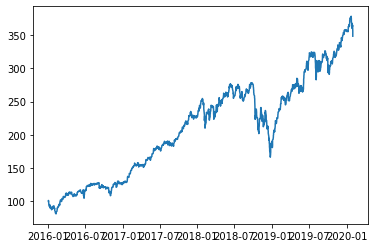

In [30]:
Plot(df20) 

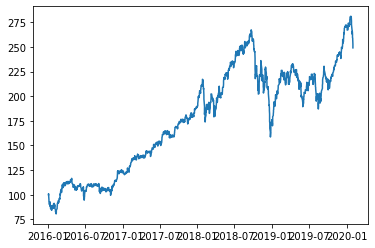

In [495]:
# n = 10
Plot(df10)

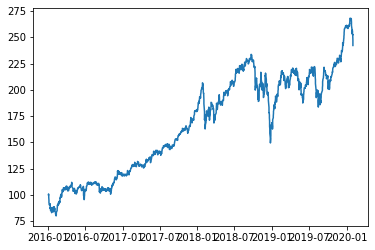

In [496]:
# n = 20
Plot(df20)

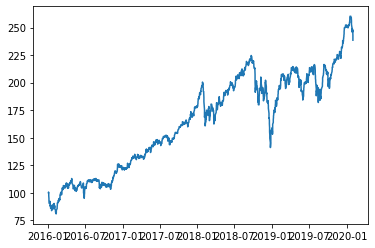

In [497]:
# n = 30
Plot(df30)

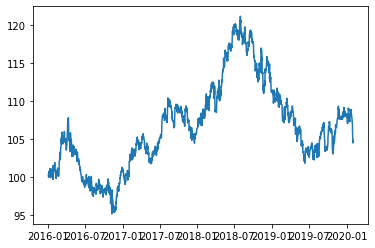

In [499]:
Plot(df10 - df30)

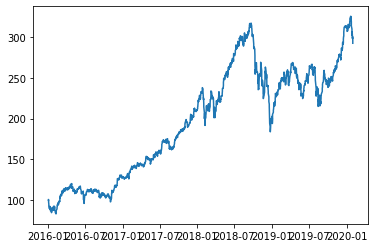

In [469]:
# n = 6
Plot(df)

Requesting BBG for: SPX Index


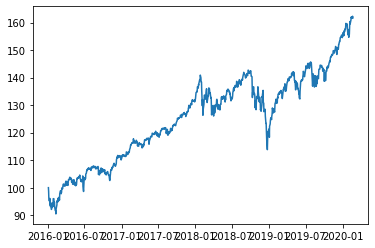

In [473]:
Plot(GetRet("SPX Index", "20160101", "20200220"))

In [481]:
(df).mean() / (df).std()

0.057274580025303966

In [475]:
SPX = GetRet("SPX Index", "20160101", pd.Timestamp.today().strftime("%Y%m%d"))

Requesting BBG for: SPX Index
Requesting BBG for: SPX Index


In [ ]:
1+1